# Dual-Dataset Approach - Sequential Training & Testing (Concept Drift)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib  # For loading/saving models and data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Will be used for models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, f1_score, precision_score, recall_score

In [2]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size for plots

In [3]:
# Define a random state for reproducibility
RANDOM_STATE = 42

Define Evaluation Function

In [4]:
# --- 1. Define Evaluation Function ---
# This function will be reused for all model evaluations.
def evaluate_model(model, X_test, y_test, model_name, strategy_name, results_list):
    """
    Evaluates a trained classification model and prints key metrics,
    plots the Precision-Recall curve, and stores results.
    
    Args:
        model: Trained scikit-learn compatible classifier.
        X_test: Test features.
        y_test: True test labels.
        model_name (str): Name of the model.
        strategy_name (str): Description of the evaluation strategy (e.g., 'Trained on 2013, Tested on 2013').
        results_list (list): List to append model results.
    """
    print(f"--- Evaluating {model_name} ({strategy_name}) ---")
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of the positive class (fraud)
    
    # 1. Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix: {model_name} ({strategy_name})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    # 3. ROC AUC Score
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\nROC AUC Score: {roc_auc:.4f}")
    
    # 4. Precision-Recall Curve & AUPRC
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    print(f"Precision-Recall AUC (AUPRC): {pr_auc:.4f}")
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='darkorange', lw=2,
             label=f'PR curve (area = {pr_auc:.2f})')
    plt.xlabel('Recall (Fraud)')
    plt.ylabel('Precision (Fraud)')
    plt.title(f'Precision-Recall Curve: {model_name} ({strategy_name})')  # Fixed syntax error
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Store results for later comparison
    metrics = {
        'Model': model_name,
        'Strategy': strategy_name,
        'Accuracy': (cm[0,0] + cm[1,1]) / np.sum(cm),
        'Precision (Fraud)': precision_score(y_test, y_pred, pos_label=1, zero_division=0),  # zero_division=0 to handle cases with no positive predictions
        'Recall (Fraud)': recall_score(y_test, y_pred, pos_label=1, zero_division=0),
        'F1-Score (Fraud)': f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        'ROC AUC': roc_auc,
        'AUPRC': pr_auc,
        'True Positives (TP)': cm[1,1],
        'False Positives (FP)': cm[0,1],
        'False Negatives (FN)': cm[1,0]
    }
    results_list.append(metrics)
    print("\n" + "="*80 + "\n")  # Separator

Load Raw Datasets & Define Common Features

In [5]:
# --- 2. Load Raw Datasets & Define Common Features ---
print("--- 2. Loading Raw Datasets & Defining Common Features ---")

# Load original 2013 and 2023 datasets for consistent feature processing
try:
    df_2013_raw = pd.read_csv('../data/creditcard.csv')
    df_2023_raw = pd.read_csv('../data/creditcard_2023.csv')
    print("Raw 2013 and 2023 datasets loaded successfully.")
except FileNotFoundError:
    print("Error: Raw datasets not found. Please ensure 'creditcard.csv' and 'creditcard_2023.csv' are in the '../data/' directory.")
    exit()

--- 2. Loading Raw Datasets & Defining Common Features ---
Raw 2013 and 2023 datasets loaded successfully.


In [6]:
# Define common features (V1-V28 and Amount)
# These are the features present in both datasets without transformation discrepancies (like 'Time' vs 'id')
common_features = [f'V{i}' for i in range(1, 29)] + ['Amount']
target_column = 'Class'
print(f"Common features identified: {common_features[:5]}...{common_features[-5:]}")

Common features identified: ['V1', 'V2', 'V3', 'V4', 'V5']...['V25', 'V26', 'V27', 'V28', 'Amount']


In [7]:
# Prepare X and y for 2013 dataset (only common features for split)
X_2013_common_raw = df_2013_raw[common_features]
y_2013 = df_2013_raw[target_column]

In [ ]:
# Prepare X and y for 2023 dataset (only common features)
X_2023_common_raw_full = df_2023_raw[common_features]  
y_2023_full = df_2023_raw[target_column]  # Use full 2023 data for drift testing

In [9]:
print(f"X_2013_common_raw shape: {X_2013_common_raw.shape}, y_2013 shape: {y_2013.shape}")
print(f"X_2023_common_raw_full shape: {X_2023_common_raw_full.shape}, y_2023_full shape: {y_2023_full.shape}")

X_2013_common_raw shape: (284807, 29), y_2013 shape: (284807,)
X_2023_common_raw_full shape: (568630, 29), y_2023_full shape: (568630,)


In [10]:
# Verify missing values in raw datasets
print("\nMissing Values Check (Raw Data):")
print("2013 X_common_raw:", X_2013_common_raw.isnull().sum().sum())
print("2023 X_common_raw_full:", X_2023_common_raw_full.isnull().sum().sum())
print("\n" + "="*80 + "\n")


Missing Values Check (Raw Data):
2013 X_common_raw: 0
2023 X_common_raw_full: 0




Train-Test Split for 2013 Data (for model training)

In [11]:
# --- 3. Train-Test Split for 2013 Data (for model training) ---
print("--- 3. Train-Test Split for 2013 Data ---")

# Split 2013 data for training the "old" model and testing its native performance
# Stratify is crucial here due to the severe imbalance in the 2013 dataset
X_train_2013_raw, X_test_2013_raw, y_train_2013, y_test_2013 = train_test_split(
    X_2013_common_raw, y_2013, test_size=0.20, random_state=RANDOM_STATE, stratify=y_2013
)

print(f"2013 training raw shape: {X_train_2013_raw.shape}, 2013 testing raw shape: {X_test_2013_raw.shape}")
print(f"2013 training class distribution:\n{y_train_2013.value_counts(normalize=True) * 100}")
print(f"2013 testing class distribution:\n{y_test_2013.value_counts(normalize=True) * 100}")
print("\n" + "="*80 + "\n")

--- 3. Train-Test Split for 2013 Data ---
2013 training raw shape: (227845, 29), 2013 testing raw shape: (56962, 29)
2013 training class distribution:
Class
0    99.827075
1     0.172925
Name: proportion, dtype: float64
2013 testing class distribution:
Class
0    99.827955
1     0.172045
Name: proportion, dtype: float64




Consistent Scaling (Simulating Real-World Drift Scenario)

In [12]:
# --- 4. Consistent Scaling (Simulating Real-World Drift Scenario) ---
print("--- 4. Consistent Scaling for Concept Drift Analysis ---")

# In a real drift scenario, the old model's scaler (trained on old data) is used on new data.
# Re-initialize and fit StandardScaler ONLY on 2013 training data.
scaler_2013_drift = StandardScaler()
X_train_2013_scaled = scaler_2013_drift.fit_transform(X_train_2013_raw)
X_train_2013_scaled = pd.DataFrame(X_train_2013_scaled, columns=common_features)  # Convert back to DataFrame for consistency

X_test_2013_scaled = scaler_2013_drift.transform(X_test_2013_raw)  # Transform 2013 test set with 2013 scaler
X_test_2013_scaled = pd.DataFrame(X_test_2013_scaled, columns=common_features)

# Apply the *same 2013-fitted scaler* to the *entire 2023 dataset*
X_2023_scaled_for_drift_test = scaler_2013_drift.transform(X_2023_common_raw_full)
X_2023_scaled_for_drift_test = pd.DataFrame(X_2023_scaled_for_drift_test, columns=common_features)

print("Features scaled consistently using only 2013 training data's scale.")
print(f"Shape of scaled 2013 train: {X_train_2013_scaled.shape}")
print(f"Shape of scaled 2013 test: {X_test_2013_scaled.shape}")
print(f"Shape of scaled 2023 full for drift test: {X_2023_scaled_for_drift_test.shape}")

--- 4. Consistent Scaling for Concept Drift Analysis ---
Features scaled consistently using only 2013 training data's scale.
Shape of scaled 2013 train: (227845, 29)
Shape of scaled 2013 test: (56962, 29)
Shape of scaled 2023 full for drift test: (568630, 29)


In [13]:
# Verify feature alignment
print("\nFeature Check:")
print("2013 Train Features:", X_train_2013_scaled.columns.tolist())
print("2013 Test Features:", X_test_2013_scaled.columns.tolist())
print("2023 Full Features:", X_2023_scaled_for_drift_test.columns.tolist())
assert X_train_2013_scaled.columns.tolist() == X_test_2013_scaled.columns.tolist() == X_2023_scaled_for_drift_test.columns.tolist(), "Feature mismatch!"


Feature Check:
2013 Train Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
2013 Test Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
2023 Full Features: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [14]:
# Verify scaling
print("\nScaling Check (2013 Train):")
print(X_train_2013_scaled.describe()[['V1', 'Amount']].loc[['mean', 'std']])
print("\nScaling Check (2013 Test):")
print(X_test_2013_scaled.describe()[['V1', 'Amount']].loc[['mean', 'std']])
print("\nScaling Check (2023 Full):")
print(X_2023_scaled_for_drift_test.describe()[['V1', 'Amount']].loc[['mean', 'std']])

print("\nInsight: Feature scaling has been applied consistently based on 2013 training data. This ensures that the 2013-trained model will process 2023 data using the same feature transformations it learned from, simulating a real-world drift scenario.")


Scaling Check (2013 Train):
                V1        Amount
mean  8.420046e-19 -2.020811e-17
std   1.000002e+00  1.000002e+00

Scaling Check (2013 Test):
            V1    Amount
mean -0.002030  0.003456
std   0.999423  0.987933

Scaling Check (2023 Full):
            V1     Amount
mean -0.000406  47.677423
std   0.510485  27.598867

Insight: Feature scaling has been applied consistently based on 2013 training data. This ensures that the 2013-trained model will process 2023 data using the same feature transformations it learned from, simulating a real-world drift scenario.


In [15]:
# Save scaled datasets for next steps
joblib.dump(
    {
        'X_train_2013_scaled': X_train_2013_scaled,
        'X_test_2013_scaled': X_test_2013_scaled,
        'y_train_2013': y_train_2013,
        'y_test_2013': y_test_2013,
        'X_2023_scaled_for_drift_test': X_2023_scaled_for_drift_test,
        'y_2023_full': y_2023_full
    },
    '../data/preprocessed_data_phase3.pkl'
)
joblib.dump(scaler_2013_drift, '../data/scaler_2013_drift.pkl')
print("\nScaled datasets and scaler saved to '../data/preprocessed_data_phase3.pkl' and '../data/scaler_2013_drift.pkl'")
print("\n" + "="*80 + "\n")


Scaled datasets and scaler saved to '../data/preprocessed_data_phase3.pkl' and '../data/scaler_2013_drift.pkl'




Load Scaled Data

In [16]:
# --- 5. Load Scaled Data from Phase 3 Setup ---
print("--- 5. Loading Scaled Data from preprocessed_data_phase3.pkl ---")

# Load scaled datasets from saved .pkl file to ensure consistency
try:
    loaded_phase3_data = joblib.load('../data/preprocessed_data_phase3.pkl')
    X_train_2013_scaled = loaded_phase3_data['X_train_2013_scaled']
    X_test_2013_scaled = loaded_phase3_data['X_test_2013_scaled']
    y_train_2013 = loaded_phase3_data['y_train_2013']
    y_test_2013 = loaded_phase3_data['y_test_2013']
    X_2023_scaled_for_drift_test = loaded_phase3_data['X_2023_scaled_for_drift_test']
    y_2023_full = loaded_phase3_data['y_2023_full']
    print("Scaled data for Phase 3 loaded successfully.")
except FileNotFoundError:
    print("Error: 'preprocessed_data_phase3.pkl' not found. Ensure previous steps were completed.")
    exit()

--- 5. Loading Scaled Data from preprocessed_data_phase3.pkl ---
Scaled data for Phase 3 loaded successfully.


In [17]:
# Verify loaded data shapes
print(f"Loaded X_train_2013_scaled shape: {X_train_2013_scaled.shape}, y_train_2013 shape: {y_train_2013.shape}")
print(f"Loaded X_test_2013_scaled shape: {X_test_2013_scaled.shape}, y_test_2013 shape: {y_test_2013.shape}")
print(f"Loaded X_2023_scaled_for_drift_test shape: {X_2023_scaled_for_drift_test.shape}, y_2023_full shape: {y_2023_full.shape}")
print("\n" + "="*80 + "\n")

Loaded X_train_2013_scaled shape: (227845, 29), y_train_2013 shape: (227845,)
Loaded X_test_2013_scaled shape: (56962, 29), y_test_2013 shape: (56962,)
Loaded X_2023_scaled_for_drift_test shape: (568630, 29), y_2023_full shape: (568630,)




Train Best Model from Phase 1 (2013 Data)

In [18]:
# --- 6. Train Best Model from Phase 1 (2013 Data) ---
print("--- 6. Training Best Model from Phase 1 (XGBoost on 2013 Data) ---")

# Initialize list to store results for Phase 3
concept_drift_results = []  # Re-initialize to store results for all evaluations

# Identify scale_pos_weight for 2013 training data (re-calculate for clarity, even if it's the same value)
scale_pos_weight_2013 = (y_train_2013 == 0).sum() / (y_train_2013 == 1).sum()
print(f"Calculated scale_pos_weight for 2013 data: {scale_pos_weight_2013:.2f}")


--- 6. Training Best Model from Phase 1 (XGBoost on 2013 Data) ---
Calculated scale_pos_weight for 2013 data: 577.29


In [19]:
# Instantiate and train XGBoost Classifier (best model from Phase 1)
# Using parameters as determined in Phase 1 (n_estimators=100 is typical for initial run)
xgb_2013_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_2013,
    random_state=RANDOM_STATE,
    n_estimators=100,
    n_jobs=-1
)
xgb_2013_model.fit(X_train_2013_scaled, y_train_2013)
print("XGBoost model trained on 2013 data successfully.")

C:\Users\PAVITHRAN\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [15:41:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost model trained on 2013 data successfully.


In [20]:
# Save the trained model for use in subsequent steps
joblib.dump(xgb_2013_model, '../data/xgb_model_2013.pkl')
print("Trained XGBoost model saved to '../data/xgb_model_2013.pkl'")
print("\n" + "="*80 + "\n")


Trained XGBoost model saved to '../data/xgb_model_2013.pkl'




Evaluate 2013 Model on 2013 Test Data (Baseline Performance)

--- 7. Evaluating 2013 Model on 2013 Test Data (Native Performance) ---
--- Evaluating XGBoost (2013) (Trained on 2013, Tested on 2013) ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962


Confusion Matrix:
[[56853    11]
 [   15    83]]


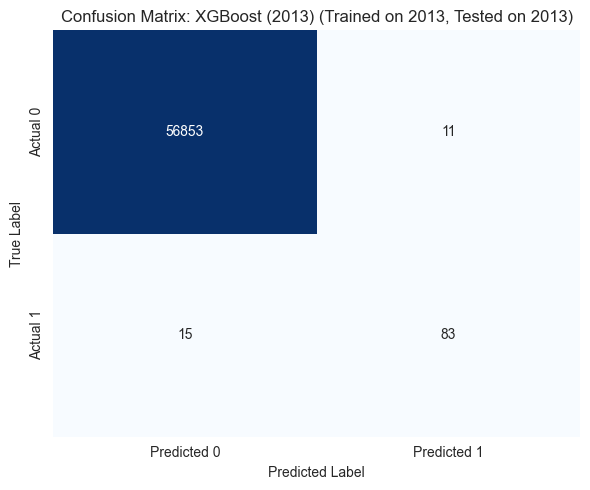


ROC AUC Score: 0.9691
Precision-Recall AUC (AUPRC): 0.8811


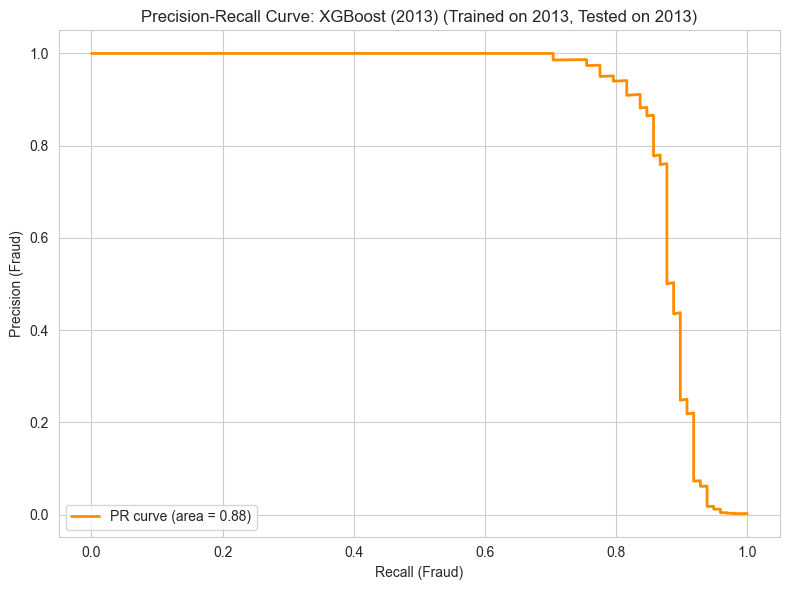

In [21]:
# --- 7. Evaluate 2013 Model on 2013 Test Data (Baseline Performance) ---
print("--- 7. Evaluating 2013 Model on 2013 Test Data (Native Performance) ---")

# This evaluation shows how well the 2013-trained model performs on data from its own time period.
evaluate_model(
    xgb_2013_model,
    X_test_2013_scaled,
    y_test_2013,
    'XGBoost (2013)',
    'Trained on 2013, Tested on 2013',
    concept_drift_results
)

In [22]:
# Save results for later comparison
joblib.dump(concept_drift_results, '../data/phase3_results_2013_test.pkl')
print("Evaluation results for 2013 test data saved to '../data/phase3_results_2013_test.pkl'")
print("\n" + "="*80 + "\n")

Evaluation results for 2013 test data saved to '../data/phase3_results_2013_test.pkl'




Load Previous Results and Data

In [23]:
# --- 8. Load Previous Results and Data  ---
print("--- 8. Loading Previous Results and Data ---")

# Load previous results and data to continue analysis if the kernel was restarted
try:
    # Load the results list from the previous evaluation
    concept_drift_results = joblib.load('../data/phase3_results_2013_test.pkl')
    # Load all scaled data necessary for this part
    loaded_phase3_data = joblib.load('../data/preprocessed_data_phase3.pkl')
    X_2023_scaled_for_drift_test = loaded_phase3_data['X_2023_scaled_for_drift_test']
    y_2023_full = loaded_phase3_data['y_2023_full']
    # Load the trained 2013 model
    xgb_2013_model = joblib.load('../data/xgb_model_2013.pkl')
    print("Previous results and required data/model loaded successfully.")
except FileNotFoundError:
    print("Error: Required files not found. Ensure previous steps were completed and data saved.")
    exit()

print("\n" + "="*80 + "\n")


--- 8. Loading Previous Results and Data ---
Previous results and required data/model loaded successfully.




CRUCIAL STEP: Evaluate 2013 Model on 2023 Data (Demonstrate Drift)

--- 9. Evaluating 2013 Model on 2023 Data (Concept Drift Test) ---
--- Evaluating XGBoost (2013) (Trained on 2013, Tested on 2023 (Concept Drift)) ---

Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68    284315
           1       1.00      0.06      0.11    284315

    accuracy                           0.53    568630
   macro avg       0.76      0.53      0.40    568630
weighted avg       0.76      0.53      0.40    568630


Confusion Matrix:
[[284315      0]
 [267102  17213]]


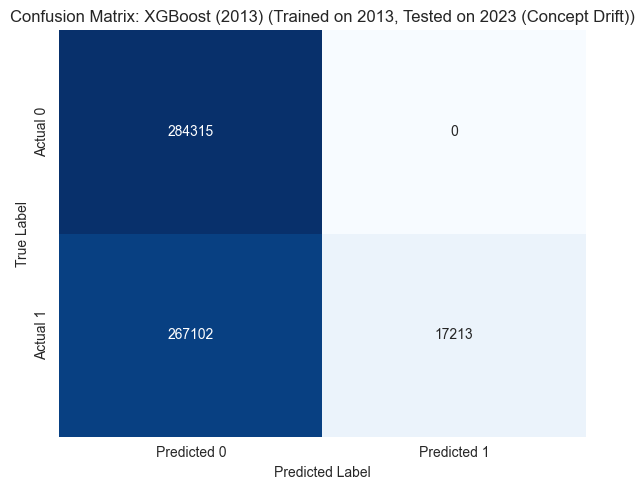


ROC AUC Score: 0.9108
Precision-Recall AUC (AUPRC): 0.9258


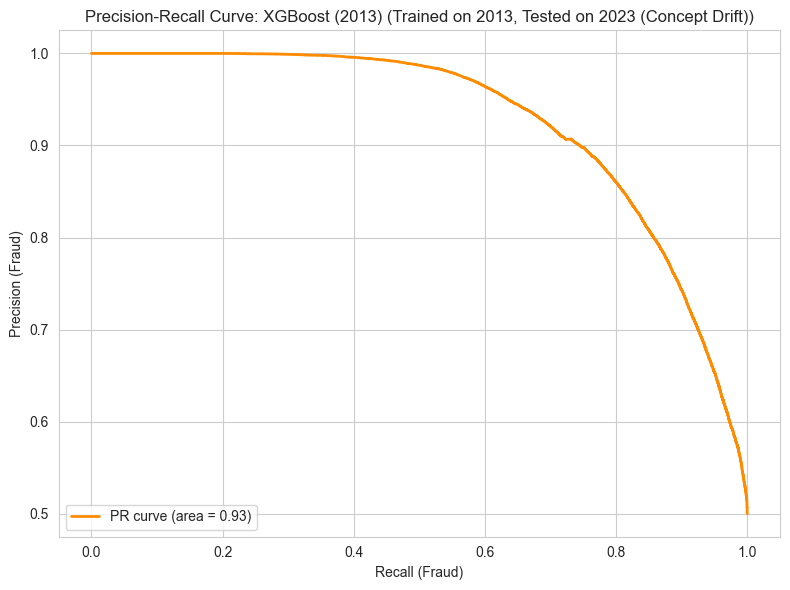

In [24]:
# --- 9. CRUCIAL STEP: Evaluate 2013 Model on 2023 Data (Demonstrate Drift) ---
print("--- 9. Evaluating 2013 Model on 2023 Data (Concept Drift Test) ---")

# Apply the model trained on 2013 data (using its scaler) to the scaled 2023 data.
# This will show the performance degradation due to concept drift.
evaluate_model(
    xgb_2013_model,
    X_2023_scaled_for_drift_test,
    y_2023_full,
    'XGBoost (2013)',
    'Trained on 2013, Tested on 2023 (Concept Drift)',
    concept_drift_results
)

print("\n" + "="*80 + "\n")

Evaluate Best Model from Phase 2 (2023 Data) for Direct Comparison

--- 10. Evaluating Best Model from Phase 2 (Random Forest on 2023 Data) ---
2023 preprocessed data and best model loaded successfully.
--- Evaluating Random Forest (2023) (Trained on 2023, Tested on 2023 (Ideal)) ---

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726


Confusion Matrix:
[[56844    19]
 [    0 56863]]


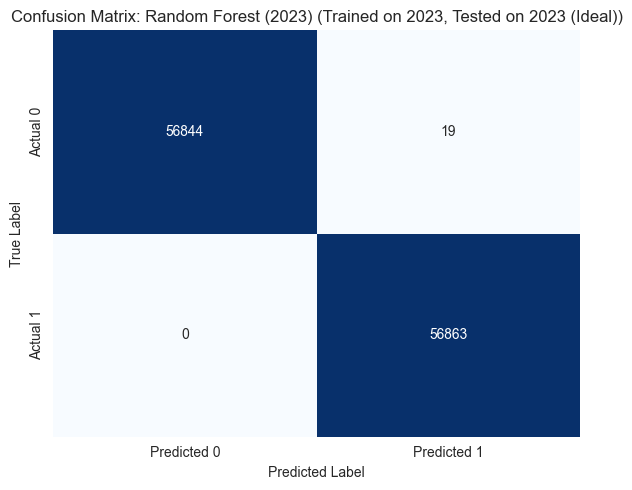


ROC AUC Score: 1.0000
Precision-Recall AUC (AUPRC): 1.0000


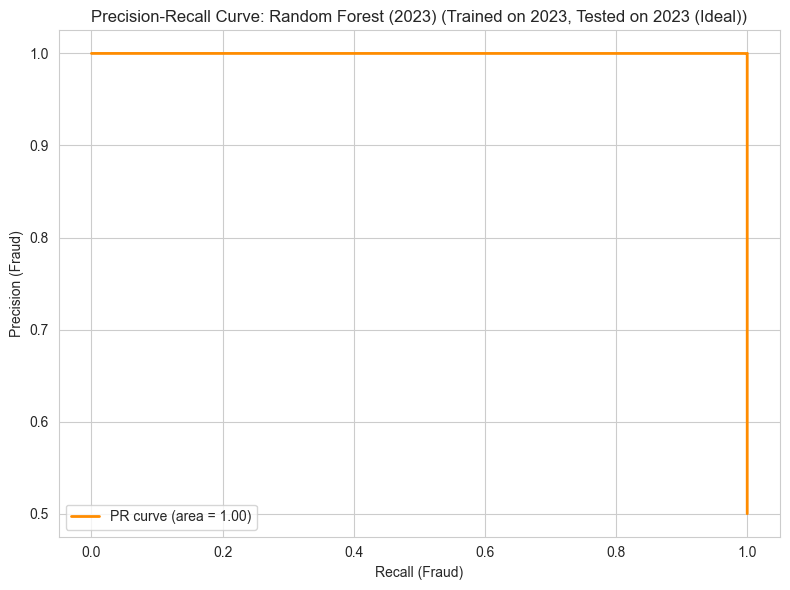

In [25]:
# --- 10. Evaluate Best Model from Phase 2 (2023 Data) for Direct Comparison ---
print("--- 10. Evaluating Best Model from Phase 2 (Random Forest on 2023 Data) ---")

# Load the best 2023 model (Random Forest) and its preprocessed test set from Phase 2
try:
    X_train_2023_orig_scaled, X_test_2023_orig_scaled, y_train_2023_orig, y_test_2023_orig = joblib.load('../data/preprocessed_data_2023.pkl')
    rf_2023_model = joblib.load('../data/best_model_2023_random_forest_balanced_data.pkl')
    print("2023 preprocessed data and best model loaded successfully.")
except FileNotFoundError:
    print("Error: 2023 preprocessed data or best model not found. Ensure paths are correct and Phase 2 was completed.")
    exit()

evaluate_model(
    rf_2023_model,
    X_test_2023_orig_scaled,
    y_test_2023_orig,
    'Random Forest (2023)',
    'Trained on 2023, Tested on 2023 (Ideal)',
    concept_drift_results
)

print("\n" + "="*80 + "\n")

Analysis & Discussion Summary for Concept Drift

In [26]:
# --- 11. Analysis & Discussion Summary for Concept Drift ---
print("--- 11. Analysis & Discussion Summary for Concept Drift ---")

concept_drift_df = pd.DataFrame(concept_drift_results)

# Sort by AUPRC for comparison
concept_drift_df_sorted = concept_drift_df.sort_values(by='AUPRC', ascending=False)

print("\nSummary of Concept Drift Analysis Performance:")
print(concept_drift_df_sorted[['Model', 'Strategy', 'Accuracy', 'Precision (Fraud)', 'Recall (Fraud)', 'F1-Score (Fraud)', 'AUPRC', 'ROC AUC', 'True Positives (TP)', 'False Positives (FP)', 'False Negatives (FN)']
].round(4))

print("\nInsight: The performance drop of the 2013-trained model when applied to 2023 data quantifies concept drift. Compare this to the 2023-trained model's ideal performance on 2023 data.")
print("This highlights the necessity for continuous model adaptation in real-world fraud detection.")

print("\n" + "="*80 + "\n")

--- 11. Analysis & Discussion Summary for Concept Drift ---

Summary of Concept Drift Analysis Performance:
                  Model                                         Strategy  \
2  Random Forest (2023)          Trained on 2023, Tested on 2023 (Ideal)   
1        XGBoost (2013)  Trained on 2013, Tested on 2023 (Concept Drift)   
0        XGBoost (2013)                  Trained on 2013, Tested on 2013   

   Accuracy  Precision (Fraud)  Recall (Fraud)  F1-Score (Fraud)   AUPRC  \
2    0.9998             0.9997          1.0000            0.9998  1.0000   
1    0.5303             1.0000          0.0605            0.1142  0.9258   
0    0.9995             0.8830          0.8469            0.8646  0.8811   

   ROC AUC  True Positives (TP)  False Positives (FP)  False Negatives (FN)  
2   1.0000                56863                    19                     0  
1   0.9108                17213                     0                267102  
0   0.9691                   83                 

 Amount distribution (2013 vs. 2023)

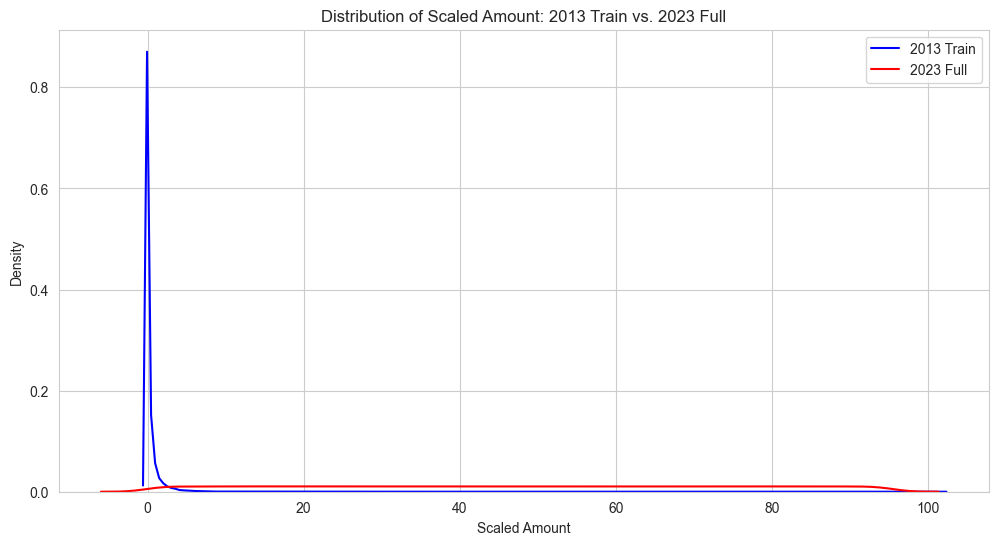

In [27]:
plt.figure(figsize=(12, 6))
sns.kdeplot(X_train_2013_scaled['Amount'], label='2013 Train', color='blue')
sns.kdeplot(X_2023_scaled_for_drift_test['Amount'], label='2023 Full', color='red')
plt.title('Distribution of Scaled Amount: 2013 Train vs. 2023 Full')
plt.xlabel('Scaled Amount')
plt.ylabel('Density')
plt.legend()
plt.show()